# Kamiar Coffey

# Using A Neural Net To Predict The Best Players For Fantasy Premier League

This jupyter notebook is a walk-through of my work so far. It includes all the code from the python files, and can be run as a stand-alone. As is, some cells are commented-out because they pull from the fantasy premier league site: https://fantasy.premierleague.com/drf/... All data from these APIs has been dowloaded locally, parsed, and stored as .json files in the main directory. Subsequent cells reference these files, but the original API calls can be used to overwrite and refresh JSON files.

Some useful abbreviations. I will use the periodically in the write-up:
- FPL = Fantasy Premier League
- PL = Premier League
- ML/NN = Machine Learning / Neural Net (will often be the names of variables in code too that refer to a neural net object)


# 1. A description of the problem I am considering


I will create a machine learning program (using a neural network) to help in drafting players for fantasy Premier League. Fantasy Premier league is an online platform that lets groups of people “draft” a team – i.e. create a set of players – from the English Premier League. Players accumulate points on various metrics of gameplay, and the winning fantasy owner is the person whose team has cumulatively earned the most points. Winning is not trivial. My solution is to create a tool that makes winning easier. This addresses multiple problems:
 - First: It remains an undecided problem what characteristics make a good soccer (aka football) player. Should we measure physical attributes like speed, height, or ball-touches per game? Or should we look at previous year’s performance? How useful is a previous year’s performance? For example, player stats do fluctuate year to year. Are some players better in winter months? Can stats be influenced by which team a player plays for? This method solves these issues because a neural net will address these problems by selecting the best factors.

- Second: There is not a direct one-to-one map between player “performance” and points awarded in the draft system. Instead, points are awarded according to the lookup table for various actions shown here in the appendix. The machine learning system is similarly suited to develop its own weights for these actions given their point contributions.


Below is a table of how actions during a game are mapped to FPL points [3]. I will use these items as features:

| ﻿Action 	| Points 	|
|----------------------------------------------------	|--------	|
| Playing up to 60 minutes 	| 1 	|
| Playing 60 minutes or more (excluding injury time) 	| 2 	|
| Goal scored by a goalkeeper or defender 	| 6 	|
| Goal scored by a midfielder 	| 5 	|
| Goal scored by a forward 	| 4 	|
| Goal assist 	| 3 	|
| Clean sheet by a goalkeeper or defender 	| 4 	|
| Clean sheet by a midfielder 	| 1 	|
| Every 3 saves by a goalkeeper 	| 1 	|
| Penalty save 	| 5 	|
| Penalty miss 	| -2 	|
| Being among the best players in a match 	| 2 	|
| Every 2 goals conceded by a goalkeeper or defender 	| -1 	|
| Yellow card 	| -1 	|
| Red card 	| -3 	|
| Own goal 	| -2 	|

# 2. A description of methods, in-depth description and assumptions

**Overview**
There are two parts to the methods: wrangling the data and building the neural net. A detailed walk-through of my process is below. Here is a high-level overview of the architecture used and assumptions made. 

**High-Level Data Collection**
Data from the Premier League API comes in the form of data per game. So, to build the data set, I called the API for each player and each game and created a python dictionary where each key value pair was a player and his features vector. The features vector is the sum of each game's features vector for that player.

**Neural Net Architecture**

I implemented a neural net which takes as input an input vector of 35 integers. Each position in the input vector corresponds to a specific action-event which occured during the 2018 Premier League season. For example, one entry is number of goals scored, a second is number of yellow cards awarded. A full list of these features is included below. 

The neural net has as output a vector of length one (a single number) which represents the total number of FPL points awarded for a single player over an entire season. This output was chosen because an FPL player's team's total score is the sum of every player on the roster's FPL points over the duration that they were on the roster. 

The network has one hidden layer. As such, it has two vectors of weights: weights1 and weights2. Weights1 maps the input vector to the hidden layer and weights2 maps the hidden layer to the output.


**Neural Net Mechanics**
To train the model, I passed in 587 input vectors and 587 of their corresponding output vectors, each group corresponding to a single player. Ingesting all this training data a single time is considered a single epoch [5]. The model was trained on around 1000 epochs.

Weights were initialized to random fractions whose absolute value is less than one. This is because some features, like yellow cards cause players to loose points.
$$\{|x_1|...|x_n|\} \in w1, \{y_1|...|y_n|\} \in w_2 < 1 $$ 

The neural net was trained using gradient descent for forward propagation and a loss function of Sum of Squared Error (SSE) in backward propagation. SSE was chosen because the underlying data was assumed to follow a Gaussian distribution[4]

Gradient descent essentially causes the model to learn a set of weights for $w_1$ and $w_2$ which when fully trained are the solution for predicting how many FPL points a player will earn over a season given his input vector of actionable events. The actionable events can be taken from a single game and scaled by the number of games in a season to give an estimate of total points. The final points value is calculated by taking a dot product of the input vector and the weights. The neural net was built with a parameter for the learning rate, which factors into this training by adjusting the rate at which new gradient descent values are adopted by the weights data member. 

Output layer calculated by feeding forward, then feeding back.

**Feed forward:** $$z = \sigma(W_1x+b_1)$$

**Back probagation:** $$ W_2z+b_2 $$

**Where the output $\hat{y}$ is:**

$$\hat{y} = \sigma(W_2(\sigma(W_1x+b_1)+b_2)$$

**Assumptions**
- Underlying distribtion of player stats is Gaussian [2]
- Some features map to negative FPL points and some map to positive FPL points, so weights must be randomly initialized as positive or negative -- not just positive between 0 and 1
- Gradient descent will allow these weights to adjust properly in the 35 dimensional space

### Step 1: Getting The Data

In [1]:
# a list of all include statements for the entire notebook - re-run this cell if code is edited further down
import json
import requests
import lxml.html as lh
import operator
import pandas as pd
import numpy as np
from scipy import special
import scipy.stats as stats
import scipy
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
# FPL data is dumpted here, but it is aggreated not by player
STATS_URL = 'https://fantasy.premierleague.com/drf/bootstrap-static'

# FPL data is dumpted here by player where playerNumber is appended to the end of the API call string
PLAYER_URL = "https://fantasy.premierleague.com/drf/element-summary/" # [playerNumber]

**1.1 Calling The API**

It looks like the data is organized by team, then by player. This shouldn't be a problem; it will just require a little parsing and wrangling. But it raises another interesting question--would it be worthwhile to run similar Machine Learning techniques using teams as the output parameters rather than players? As in, can we use FPL data as a parameter to predict which team will end up winning the PL in real life? Let's table this for now and keep moving.

Below is a function to querry the API and dump the response

In [3]:
# better not to querry the API a million times - read it to a file
# def readAPItoFile():
#     r = requests.get(STATS_URL)
#     jsonResponse = r.json()
#     with open("leagueInfo.json", 'w') as outfile:
#         json.dump(jsonResponse, outfile)

# readAPItoFile()

Below is a function to read the JSON file into a working object for this notebook. Re-run this cell if the kernel is restarted

In [4]:
# turn the JSON into an object
def getAllPlayersDetailedJson():
    with open('leagueInfo.json') as json_data:
        dataObject = json.load(json_data)
        return dataObject

dataObject = getAllPlayersDetailedJson()

**1.2 Building The Data Set**

Below is a list of functions that will return dictionaries allowing me to use player names and player FLP primary keyIDs to lookup their total FPF points earned last season. To test if the ML model works I will need some baseline to compare my model against picking randomly. Even better than random is a naive approach that looks at just the number of FPL points earned per minute played.

In [5]:
# just for fun, lets get a list of player names. I think I'll need their playerID as the primay key, but gotta make sure this works
def getListofPlayers():
    allPlayers = getAllPlayersDetailedJson()
    namelist = []
    for entry in allPlayers["elements"]:
        namelist.append([entry['first_name'], entry['second_name']])
    return nameList

def playersToPoints():
    allPlayers = getAllPlayersDetailedJson()
    pointsPerPlayer = {}
    for entry in allPlayers["elements"]:
        pointsPerPlayer[entry['web_name']] = entry['total_points']
    return pointsPerPlayer

def playersToId():
    allPlayers = getAllPlayersDetailedJson()
    dict = {}
    for entry in allPlayers["elements"]:
        dict[entry['second_name']] = entry['id']
    return dict

def idToPlayer():
    allPlayers = getAllPlayersDetailedJson()
    dict = {}
    for entry in allPlayers["elements"]:
        dict[entry['id']] = entry['second_name']
    return dict

def findBestRatioPlayer():
    allPlayers = getAllPlayersDetailedJson()
    points_per_min = []
    for entry in allPlayers["elements"]:
        # format: ['first_name last_name', points_per_min]
        if entry['minutes'] > 0:
            points_per_min.append([entry['id'], entry['first_name']+' '+entry['second_name'], (entry['total_points']/entry['minutes'])])
    points_per_min.sort(key=lambda x: x[1], reverse=True)
    return points_per_min

def findTotalPoints():
    allPlayers = getAllPlayersDetailedJson()
    points_per_min = []
    for entry in allPlayers["elements"]:
        # format: ['first_name last_name', points_per_min]
        points_per_min.append([entry['web_name'], entry['total_points']])
    points_per_min.sort(key=lambda x: x[1], reverse=True)
    return points_per_min

ppm_df = pd.DataFrame(findBestRatioPlayer(), columns=['ID', 'Player Name', 'FPL points/minute'])
ppm_df.head(15)

totalPoints_df=pd.DataFrame(findTotalPoints(), columns=['Player Name', 'FPL Points So Far'])

**1.3 Finding A Benchmark**

Ok, there is a baseline benchmark to beat. It takes a single python function to return a sorted list of players based on the number of points awarded per minute played. This metric here is **points awarded by the Premier League Fantasy system, not points scored via goals**. In any case, it seems like a reasonable baseline metric to find the most valuable players. After the machine learning version has selected it's top players, I would hope that they are at least similar to these players, and hopefully better. I will measure this in terms of actual points awarded in the following n number of games. 

### Step 2: Designing The Neural Net

**2.1 Building NN Features**

Now we need to parse the JSON data from the API a bit more. In order to feed things into the neural net, we need them organized differently from the API dump. To build an input vector we need to reference each player's ID aka "web_name" field from the dataObject dump.

Below is a list of things that will earn a player FLP points:
1. Playing up to 60 minutes	1
2. Playing 60 minutes or more (excluding injury time)	2
3. Goal scored by a goalkeeper or defender	6
4. Goal scored by a midfielder	5
5. Goal scored by a forward	4
6. Goal assist	3
7. Clean sheet by a goalkeeper or defender	4
8. Clean sheet by a midfielder	1
9. Every 3 saves by a goalkeeper	1
9. Penalty save	5
10. Penalty miss	-2
11. Being among the best players in a match	1-3
12. Every 2 goals conceded by a goalkeeper or defender	-1
13. Yellow card	-1
14. Red card	-3
15. Own goal	-2



**Some thoughts**: 
- Some of the features that PL uses to calculated FPL points are negative. This isn't a problem, the vector weights that correspond to those will just have to end up being learned as negatives

- some of these features are specific to players of different positions. In FPL draft, you are are required to draft a certain minimum quantity of each position, and the difference between total squad size and the sum of these minimums is left as discretionary selection. For the purposes of this ML experiement, I will not attempt to parse players by category. If it so happends than forwards earn the most points of any position, then my ML model should just reccomend you to pick all forwards. Turning this into a useful application shouldn't be a problem-- use the existing ML output and just filter by highest ranked player avialable in your category of choice. 


Based on the data available, and my knowledge of how soccer games work, I have selected this list of feature lables that we can apply to each player. I have included a one-to-one map of the 15 categories that directly award points, and have found another 14 features that I think make interesting variables (such as passes attempted and completed) which map to actual high quality play).


Each player will thus be an input node with a feature vector of length 35 with a value for each of the following items:

0.  goals_scored
1.  assists
2.  clean_sheets
3.  goals_conceded
4.  own_goals
5.  penalties_saved
6.  penalties_missed
7.  yellow_cards
8.  red_cards
9.  saves
10.  open_play_crosses
11.  big_chances_created
12.  clearances_blocks_interceptions
13.  recoveries
14.  key_passes
15.  tackles
16.  winning_goals
17.  attempted_passes
18.  completed_passes
19.  penalties_conceded
20.  big_chances_missed
21.  errors_leading_to_goal
22.  errors_leading_to_goal_attempt
23.  tackled
24.  offside
25.  target_missed
26.  fouls
27.  dribbles
28.  open_play_crosses
29.  big_chances_created
30.  clearances_blocks_interceptions
31.  recoveries
32.  key_passes
33.  errors_leading_to_goal
34.  errors_leading_to_goal_attempt

In [6]:
featuresVector = ['goals_scored', 'assists', 'clean_sheets', 'goals_conceded', 'own_goals','penalties_saved','penalties_missed',
        'yellow_cards','red_cards', 'saves', 'open_play_crosses','big_chances_created','clearances_blocks_interceptions',
        'recoveries','key_passes', 'tackles','winning_goals','attempted_passes','completed_passes', 'penalties_conceded',
        'big_chances_missed','errors_leading_to_goal','errors_leading_to_goal_attempt','tackled','offside','target_missed',
        'fouls','dribbles','open_play_crosses','big_chances_created',' clearances_blocks_interceptions','recoveries',
        'key_passes','errors_leading_to_goal','errors_leading_to_goal_attempt']

**2.2 Building the Input Vector**

This call will populate the featuresVector for each player. It will call the API for each player's key then it will accumulate (sum) the features for each game of the season into a single vector, which will be the entry for a dictionary with the player's last name as the key

In [7]:
'''THIS API CALL WILL TAKE 5 MINUTES. DON'T RE-RUN UNLESS NECESSARY!
the data will be saved to the playerVectorDictionary.json file, 
and can be reloaded via the getVectorsFromJSON functon'''

# playerDataDictionary = dataObject['elements']
# playerNames = {}

# for i in playerDataDictionary:
#     playerNames[i['id']] = i['web_name']
    
# playerVectorDictionary = defaultdict(dict)

# for player in playerNames:
#     r = requests.get(PLAYER_URL + str(player))
#     data = json.loads(r.text)['history'] # this is a list of dictionary entries
#     for entry in data:
#         entryVector = [entry[feature] for feature in featuresVector]
#         playerVectorDictionary[playerNames[player]] = list(map(operator.add, playerVectorDictionary.setdefault(playerNames[player], [0]*len(entryVector)), entryVector)) # accumulate each game entry
    
# playerVectorDictionary_json = json.dumps(playerVectorDictionary)
# f = open("playerVectorDictionary.json","w")
# f.write(playerVectorDictionary_json)
# f.close()        

"THIS API CALL WILL TAKE 5 MINUTES. DON'T RE-RUN UNLESS NECESSARY!\nthe data will be saved to the playerVectorDictionary.json file, \nand can be reloaded via the getVectorsFromJSON functon"

Substitute for calling the API - use the local file

In [8]:
def getVectorsFromJSON():
    with open('playerVectorDictionary.json') as json_data:
        dataObject = json.load(json_data)
        return dataObject
    
playerVectorDictionary = getVectorsFromJSON()

The dictionary **playerVectorDictionary** now includes an entry with the last name of each player as the key and their input vector as the weights. From earlier, we also have a list of players by their total points scored per season. We will use playerVectorDictionary as our input vecctor $x$ and total points as y in the Neural Network. Since the current network only has one layer, I will need to find some way of running its weights for each player. Lets just see what happens to the weights when we do it for one player

In [9]:
x = np.array(list(playerVectorDictionary.values()))
y = np.array([[playersToPoints()[player]] for player in playerVectorDictionary.keys()])
print("check that vector sizes match!!", len(y), "=?", len(x))

check that vector sizes match!! 587 =? 587


**2.3 Choosing A Loss Function**

1. SSE (Sum squared errors)
2. Mean squared Log Error
4. Cross-Entropy Loss
5. Kullback Leibler Divergence?

**2.4 Building The Machinery**


I will define $W_1$ as the weights corresponding to the layer fron inputs to the hidden layer and $W_2$ as the weights from the hidden layer to the output later. $x$ will be the input vector and $\hat{y}$ the output vector.

Output layer calculated by feeding forward, then feeding back.

**Feed forward:** $$z = \sigma(W_1x+b_1)$$

**Back probagation:** $$ W_2z+b_2 $$

**Where the output $\hat{y}$ is:**

$$\hat{y} = \sigma(W_2(\sigma(W_1x+b_1)+b_2)$$

In [10]:
# Some helper math functions

def CrossEntropy(yHat, y):
    if y == 1:
        return -log(yHat)
    else:
        return -log(1 - yHat)
    
def sigmoidDerivative(x):
    return x * (1.0 - x)

In [11]:
class NeuralNet:
    def __init__(self, x, y, iterations = 100, learningRate=.33): # give it some default parameters
        self.n_in = len(x[0]) # make the dimensionality dependent on the inputs
        self.n_out = 1
        self.n_hidden = len(x)
        size1 = (self.n_in, self.n_hidden)
        size2 = (self.n_hidden, self.n_out)
        self.weights1 = np.random.uniform(-.01, .1, size1) # weights from input to nodes
        self.weights2 = np.random.uniform(-.01, .1, size2) # weights from nodes to output
        self.iterations = iterations
        self.learningRate = learningRate
        
    def sigmoidDerivative(self, x): # basic calculus
        return x * (1 - x)

    def feedForward(self, X): # an implementation of the above equation 
        self.z = scipy.special.expit(np.dot(X, self.weights1)) # X is the vector being fed forward
        self.z_prime = np.dot(self.z, self.weights2) # has to be a parameter because we have ver 500 players to train with
        return scipy.special.expit(self.z_prime)  

    def backProp(self, x, y, update):
        self.loss = y - update # loss needs to be stored as a data member because back prop needs to re-access it
        self.loss_adjustment = self.loss * self.sigmoidDerivative(update) 
        self.z_error = self.loss_adjustment.dot(self.weights2.T)  # implementation of text book code
        self.z_adjustment = self.z_error * self.sigmoidDerivative(self.z) * self.learningRate
        self.weights1 += x.T.dot(self.z_adjustment)  
        self.weights2 += self.z.T.dot(self.loss_adjustment)

    def train(self, x, y):
        for _ in range (self.iterations):
            update = self.feedForward(x)
            self.backProp(x, y, update)
    
    def run(self, testVector):
        sum =0
        for i in range (len(self.weights1)):
            sum += testVector[i] * self.weights1[i][0]
        return sum

### Step 3: Development Testing 


**3.1 Finding A Good Learning Rate**

Below I have set up a test to see how the learning rate converges (or not) as it moves from 1 to .05

In [25]:
expectedValue_LR = []
# run a loop where each iteration is training with a different learning rate
for i in range (1, 20):
    learningRate = (1/i)
    NN = NeuralNet(x, y, 500, learningRate)
    NN.train(x, y)
    inputVector = np.array(([19, 7, 7, 37, 0, 0, 1, 0, 0, 0, 8, 6, 25, 60, 30, 11, 4, 619, 463, 0, 16, 0, 0, 52, 23, 27, 13, 22, 8, 6, 25, 60, 30, 0, 0]))
    predictedPoints = NN.run(inputVector)
    expectedValue_LR.append((learningRate, predictedPoints))

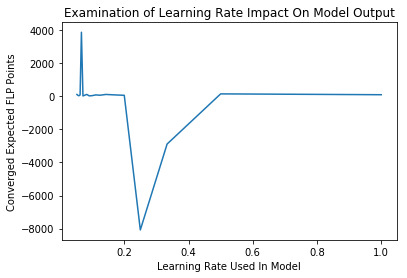

In [24]:
plt.plot(*zip(*expectedValue_LR))
plt.ylabel('Converged Expected FLP Points')
plt.xlabel('Learning Rate Used In Model')
plt.title('Examination of Learning Rate Impact On Model Output')
plt.show()

**3.2 Finding A Good Number Of Layers**

Below I have set up a test to see how the predicted output converges as the number of iterations increases

In [26]:
expectedValue_Trials = []
for i in range (1, 1000, 100):
    NN = NeuralNet(x, y, i, .3)
    NN.train(x, y)
    inputVector = np.array(([19, 7, 7, 37, 0, 0, 1, 0, 0, 0, 8, 6, 25, 60, 30, 11, 4, 619, 463, 0, 16, 0, 0, 52, 23, 27, 13, 22, 8, 6, 25, 60, 30, 0, 0]))
    predictedPoints = NN.run(inputVector)
    expectedValue_Trials.append((i, predictedPoints))

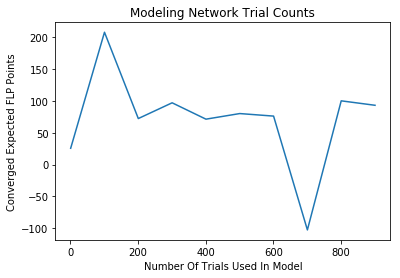

In [27]:
plt.plot(*zip(*expectedValue_Trials))
plt.ylabel('Converged Expected FLP Points')
plt.xlabel('Number Of Trials Used In Model')
plt.title("Modeling Network Trial Counts")
plt.show()

In [16]:
learningRate = 0.3
n_trials = 100
NN = NeuralNet(x, y, n_trials, learningRate)
NN.train(x, y)
inputVector = np.array(([19, 7, 7, 37, 0, 0, 1, 0, 0, 0, 8, 6, 25, 60, 30, 11, 4, 619, 463, 0, 16, 0, 0, 52, 23, 27, 13, 22, 8, 6, 25, 60, 30, 0, 0]))
predictedPoints = NN.run(inputVector)
print("The exptected FPL points earned is: ",predictedPoints)

The exptected FPL points earned is:  35.85809064481461


**3.3 Finding The Expected Points For A given Input Vector**


Given an input vector, the Model Predicts total FLP points over an entire season to be earned as: The exptected FPL points earned is:  88. This was calculated using a learning rate of 0.3 and 100 trials. Numbers heuristically chosen based off the results of development testing viewing the graphs above. Obviously this will change depending on the learning rate and layers. However, we're interested in ranking players, so there might be less variation amond the ranking indexes than the overal number of predicted points.

**3.3 Local Min/Max Topology Using Gradient Descent**

From the literature online, this problem is one quite pervasive to ML. My neural Net appears to have some bizzare local topography because the input vector is of dimensions 35 and some of those weights are negative. I think this would perform better with a pre-built ML package with better complexity, so I'll use one of those at the end to test my network.[1]

# 3. Results Discussion

**Ranking The Top Players**

In order to test how well the project is performing, I will run each Player's test set through the trained model and then rank the players (argMax) based on their modeled performance. I will then compare this ranking to the actual rankings of players by total number of points. As a refresher, below is the table of players by total points.

In [17]:
totalPoints_df.head(20)

,Player Name,FPL Points So Far
0,Salah,230
1,Hazard,224
2,Sterling,223
3,Mané,201
4,Robertson,192
5,van Dijk,188
6,Agüero,184
7,Aubameyang,182
8,Pogba,174
9,Sigurdsson,171


In [28]:
learningRate = 0.45
n_trials = 1000
NN = NeuralNet(x, y, n_trials, learningRate)
NN.train(x, y)

playerModeledPoints = []
for player in playerVectorDictionary:
    testArray = playerVectorDictionary[player]
    predictedPoints = NN.run(testArray)
    playerModeledPoints.append((player, predictedPoints))


In [29]:
playerModeledPoints.sort(key=lambda x: x[1], reverse=True)
playerModeledPoints_df = pd.DataFrame(playerModeledPoints, columns = ['Player Name', 'Predicted Points'])
playerModeledPoints_df.head(20)

,Player Name,Predicted Points
0,Jorginho,398.946781
1,van Dijk,390.013914
2,Laporte,365.173778
3,Rüdiger,341.802920
4,David Luiz,339.497284
5,Azpilicueta,319.150214
6,Alderweireld,311.044182
7,Robertson,307.074480
8,Stephens,290.338124
9,Walker,289.943442


**Interpreting Test Results**

Ok, so if you follow football you will recognize these names! That means the network is predicting what I (human) consider to be good players. They are not exactly the same as the players with the most points (but we should not expect it to be). The counts for total points are slightly lower than expected, but this is uniform accross all players, and is probably due to initializing weights, or not giving enough iterations to reach full saturation.

**Quantifying Test Results**

Two Ideas:
1. Find the difference between actual totals and predicted totals for each player -- run average and standard deviation of the mean to determine if they are statistically significantly different (hoping they are not)
2. Plot each player as a dot where the x axis is their predicted score and the y axis is their actual score.

In [30]:
actual = dict(findTotalPoints())
predicted = dict(playerModeledPoints)
comparison = {}
for player in predicted.keys():
    comparison[player] = (predicted[player], actual[player])

predicted, actual = zip(*comparison.values())
t2, p2 = stats.ttest_ind(predicted, actual)
print("t test:",t2, "p value:",p2)

t test: 9.204507394507482 p value: 1.5319091732672563e-19


**Interpreting t and p values:**

The t value of 0.08 suggest there is very little difference between the two sets (a t test of 0 means they are identical). However, the p value is not significant. This could be due to the fact that there are quite a few outlying players in the premier league who rarely play any games. In fact, if they are awarded zero points by our model but happen to score once in the year, this could very well contribute to the poor p value. We can run this same calculation again filtering for points over 10 to try to weed out strange players, but based on the graph below, it looks like the widest variation actually occurs as player points get higher!

**Updated Values**
Upon running the code a second time, the resuts t test: 9.20 p value: 1.53e-19 were obtained. This is actually the reverse of the first time: the two sets were fairly different, but the results were *highly* significant. I'm not sure what to make of this except to think that the model is iterating under a stochastic environment. For these results to be the same I would need to run the model perhaps 10,000 times, but such computation is highly intensive. The two test each take about 1-2 minutes to run on my computer as it is right now. 

**Visualizing Results**

Below is a visual guide to the results. I have plotted predicted points against actual points where each dot represents a player. As anticipated, there is a correlation! This means, the model is roughly correct in predicting actual points. However, it begins to be more wild as the total points under consideration rises. Technically, the SSD increases for samples with a greater deviation from the mean points awarded.

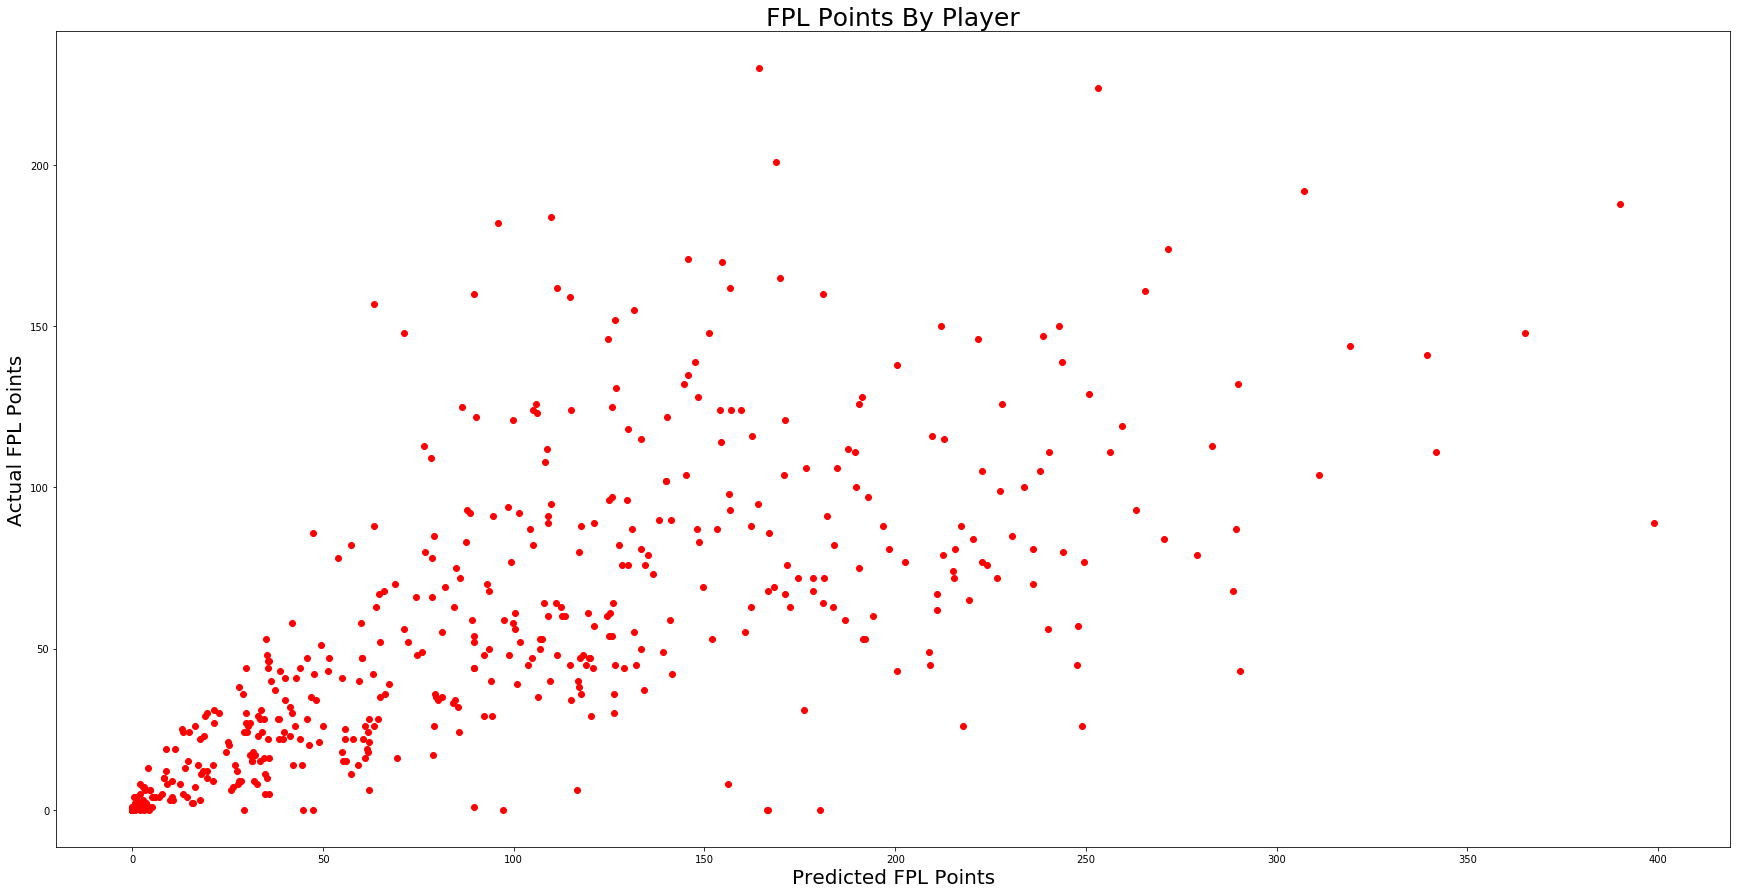

In [31]:
plt.figure(figsize=(30,15))
plt.plot(predicted, actual, 'ro')
plt.xlabel("Predicted FPL Points", fontsize=20)
plt.ylabel("Actual FPL Points", fontsize=20)
plt.title("FPL Points By Player", fontsize=25)
plt.show()

# 4. Discussion Conclusions Based On Results

**Overall Results Quality**

Overall the results are fairly good. The model predicuted high quality players, and the model's predicted FPL points matched the actual FPL points well. While the figure above does exhibit heteroskedasticity, this could be due to the use of bonus points in FPL rules, which were not modeled as part of this practicum [2]. 

In terms of quantifying these resulst, I performed a t test to test the difference between the set of predicted and actual scores. With a t value of 0.08 we can conclude that they are not very different, but the p value was 0.93, far above the industry standard of 0.05, so the results are not statistically significant no matter how visually compelling they may be. 

On a more philosophical note, it may be that we can use machine learning to preduct the quality of soccer players at all levels except the highest level. We see the SSE of a player actual vs predicted score increasing when total FPL points is above 150. There are only about 20 players in the entire league whose points *are over 150*, so it may be that "star power" is something altogether more mysterious and special than statistics let us believe....


**Potenential Improvements**

Perhaps a more complicated model would be able to pick out the fine grain details of what sets a superstar soccer player apart from his teammates. Adding more node layers to the network would be an interesting case to pursue this further. Afterall, some of the most expensive superstar players in the premier league (Paul Pogba and Alexis Sanchez) have both dazzeled for their prior teams and national teams yet are not living up to their previous goal-scoring numbers. Pogba remains quite high on the total FPL points list largegely because of passes and assists. 